## load libraries

In [2]:
library(here)
library(stringr)
library(dplyr)
library(ggplot2)
library(Seurat)
library(purrr)
library(readr)
library(patchwork)
library(scCustomize)
library(tidyverse)
library(reticulate)
#library(harmony)
#library(SeuratDisk)

here() starts at /test2/v2/scRNAseq_zebrafish_analysis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


scCustomize v2.1.2
If you find the scCustomize useful please cite.
See 'samuel-marsh.github.io/scCustomize/articles/FAQ.html' for citation info.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become er

## load data

In [2]:
filtered_seurat <- readRDS(file = here("seurat/filtered_seurat.rds"))
filtered_seurat

An object of class Seurat 
32521 features across 11105 samples within 1 assay 
Active assay: RNA (32521 features, 0 variable features)
 2 layers present: counts.control, counts.high_glucose

## Normalization

In [4]:
filtered_seurat <- Seurat::SCTransform(filtered_seurat,
    assay = 'RNA',
    new.assay.name = 'SCT',
    vst.flavor = "v2",
    variable.features.n = 4000,
    return.only.var.genes = TRUE,
    min_cells = 3,
    verbose = TRUE)

filtered_seurat

Running SCTransform on assay: RNA

Running SCTransform on layer: counts.control

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Variance stabilizing transformation of count matrix of size 23052 by 7709

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in glm.nb(formula = as.formula(new_formula), data = data):
“alternation limit reached”
Warning message in glm.nb(formula = as.formula(new_formula), data = data):
“alternation limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration

An object of class Seurat 
56194 features across 11105 samples within 2 assays 
Active assay: SCT (23673 features, 4000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

In [ ]:
normalized_seurat <- PrepSCTFindMarkers(filtered_seurat)

Found 2 SCT models. Recorrecting SCT counts using minimum median counts: 7177



In [6]:
saveRDS(normalized_seurat, file = here("seurat/normalized_seurat.rds"))

In [16]:
normalized_seurat <- readRDS(file = here("seurat/normalized_seurat.rds"))
normalized_seurat

An object of class Seurat 
56194 features across 11105 samples within 2 assays 
Active assay: SCT (23673 features, 4000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

## Dimensionality reduction

In [4]:
normalized_seurat <- RunPCA(normalized_seurat,
                     assay = 'SCT',
                     npcs = 30)

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 59 features requested have not been scaled (running reduction without them): serpina1l, serpina1, sycn.2, zgc:112265, ttr, leg1.1, cfhl4, amy2a, si:dkey-31i7.2, muc5.3, si:ch1073-464p5.5, crp3, serpinb1l4, zgc:153968, plg, chia.1, si:ch211-131k2.2, grk1b, shbg, tnnc1a, c3a.2, BX001030.1, si:dkey-96g2.1, apoea, rom1a, krt93, crygmx, crybb1l1, CELA1 (1 of many).5, grk1a, si:dkey-7i4.24, actc1c, si:ch73-361h17.1, serpinf2a, rhol, tmem86b, itih2, si:dkeyp-57d7.4, apoba, aoc1, mybpc1, cryba2a, nkl.4, gdpd3b, krt95, cnga1b, c3a.3, tspan34, trpv6, si:dkey-77g12.1, csrp3, camkk1b, si:dkey-33m11.8, or131-2, a2ml, abcb11b, CELA1 (1 of many).3, crhb, si:ch211-250m6.7”
PC_ 1 
Positive:  hsp70.2, her6, hsp70l, id1, hsp70.3, cxcr4a, si:ch73-335l21.4, fosab, igfbp1a, hsp70.1 
	   rgs5b, dll4, hey1, her15.1, esm1, sox7, tcima, rgcc, hsp90aa1.2, her9 
	   dnajb1b, cldn5b, gadd45ba, socs3a, CABZ01030107.1,

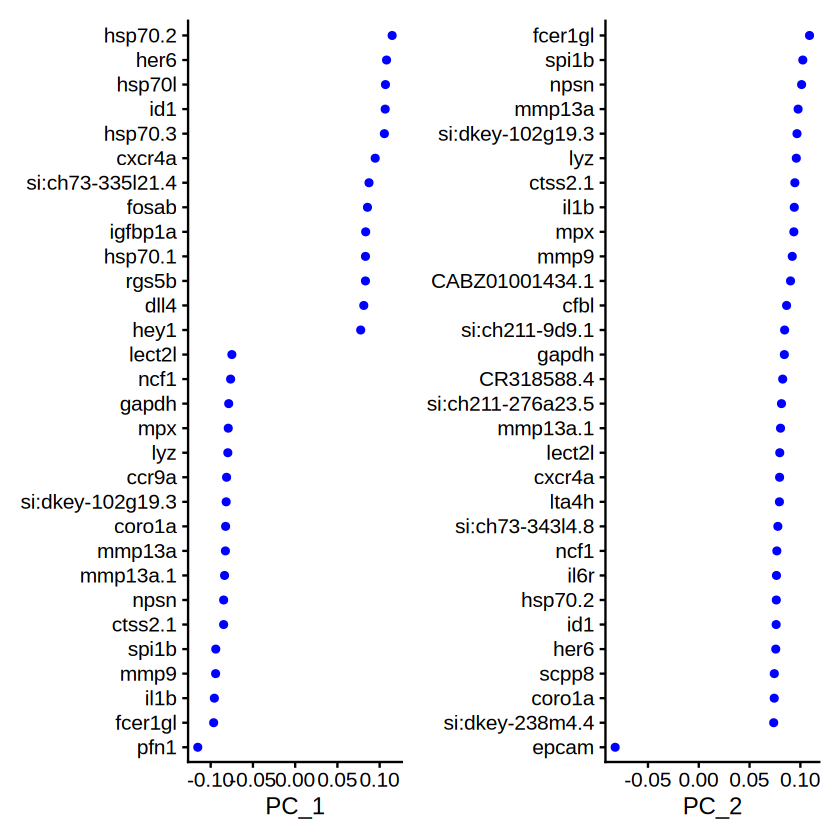

In [18]:
VizDimLoadings(normalized_seurat,
               dims = 1:2,
               reduction = "pca")

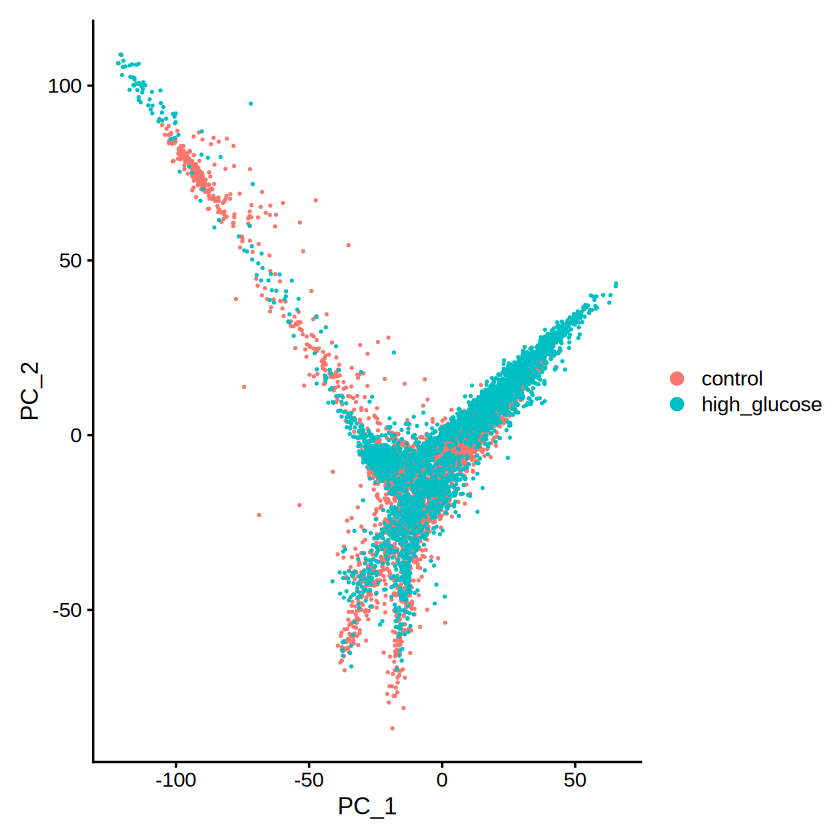

In [19]:
DimPlot(normalized_seurat, reduction = "pca")

## Clustering

In [20]:
normalized_seurat <- FindNeighbors(normalized_seurat,
                           reduction = "pca",
                           graph.name = c("pca_nn",
                                          "pca_snn"),
                           k.param = 10,
                           dims = 1:30)

Computing nearest neighbor graph

Computing SNN



In [11]:
normalized_seurat@graphs

$pca_nn
A Graph object containing 11105 cells
$pca_snn
A Graph object containing 11105 cells

In [23]:
normalized_seurat <- FindClusters(normalized_seurat,
                           graph.name = "pca_snn",
                           resolution = c(0.2, 0.3, 0.4),
                           algorithm = 4)

In [25]:
head(normalized_seurat@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,log1p_nCount_RNA,log1p_nFeature_RNA,pct_counts_in_top_20_genes,pct_counts_mt,outlier,mt_outlier,nCount_SCT,nFeature_SCT,pca_snn_res.0.2,pca_snn_res.0.3,pca_snn_res.0.4,seurat_clusters
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>
control_AAACCCAAGACCAGCA-1,control,20307,3155,9.918770,8.057061,21.19466,3.210716,FALSE,FALSE,7014,1562,2,1,2,2
control_AAACCCAAGCCTGGAA-1,control,9374,1963,9.145802,7.582738,19.70344,1.568167,FALSE,FALSE,7629,1962,2,1,2,2
control_AAACCCACACACCTAA-1,control,10715,2117,9.279493,7.658228,21.42790,3.070462,FALSE,FALSE,7725,2115,13,15,30,30
control_AAACCCACAGAACATA-1,control,6655,1959,8.803274,7.580700,21.59279,1.066867,FALSE,FALSE,6959,1959,3,5,4,4
control_AAACCCAGTGCCCAGT-1,control,5794,1795,8.664751,7.493317,26.32033,5.229548,FALSE,FALSE,6736,1793,3,5,4,4
control_AAACCCATCATTGCGA-1,control,8002,1941,8.987572,7.571474,18.75781,2.211947,FALSE,FALSE,7456,1941,17,18,19,19


## UMAP visualization

In [26]:
normalized_seurat <- RunUMAP(normalized_seurat,
                      reduction = "pca",
                      dims = 1:30,
                      reduction.name = "umap_pca"
)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:19:06 UMAP embedding parameters a = 0.9922 b = 1.112

10:19:06 Read 11105 rows and found 30 numeric columns

10:19:06 Using Annoy for neighbor search, n_neighbors = 30

10:19:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:19:07 Writing NN index file to temp file /tmp/RtmpWdjllZ/file46d04bb2e9b6

10:19:07 Searching Annoy index using 1 thread, search_k = 3000

10:19:08 Annoy recall = 100%

10:19:09 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors 

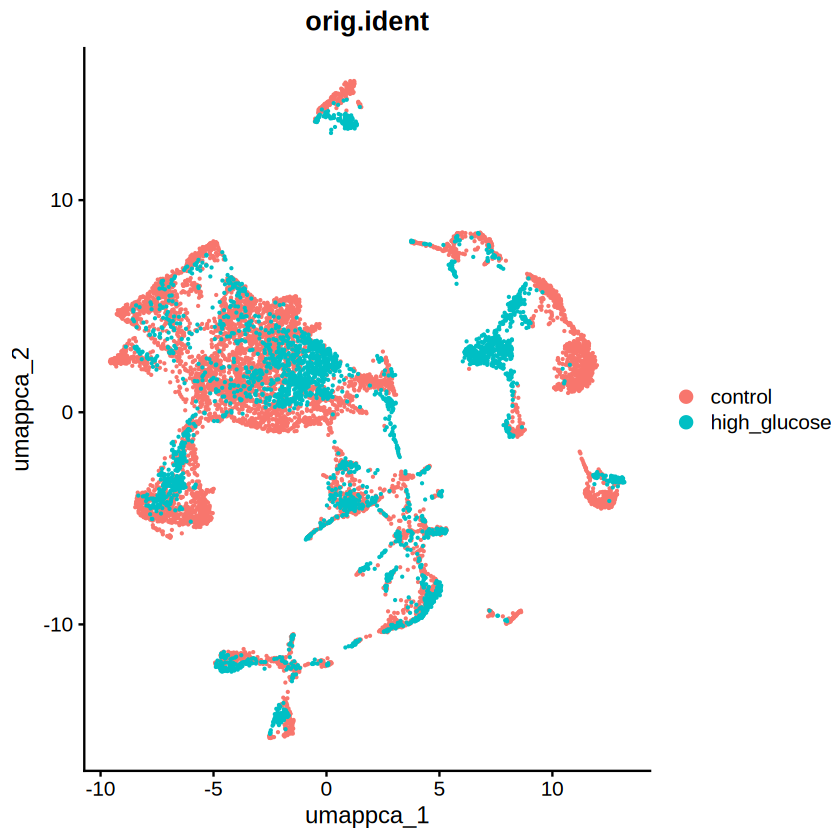

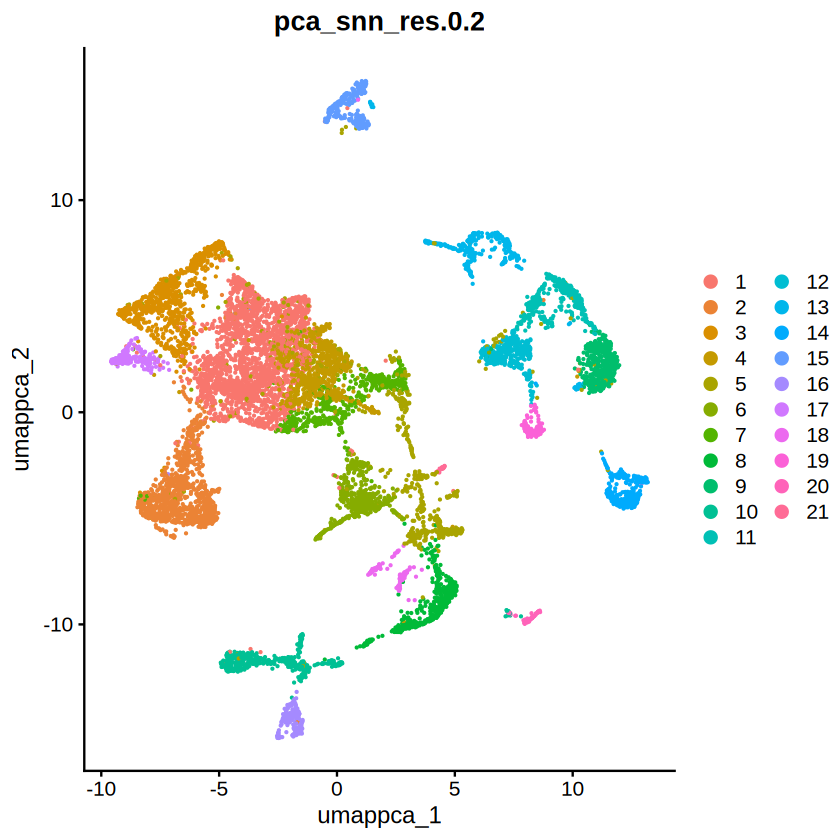

[[1]]

[[2]]

[[3]]

[[4]]


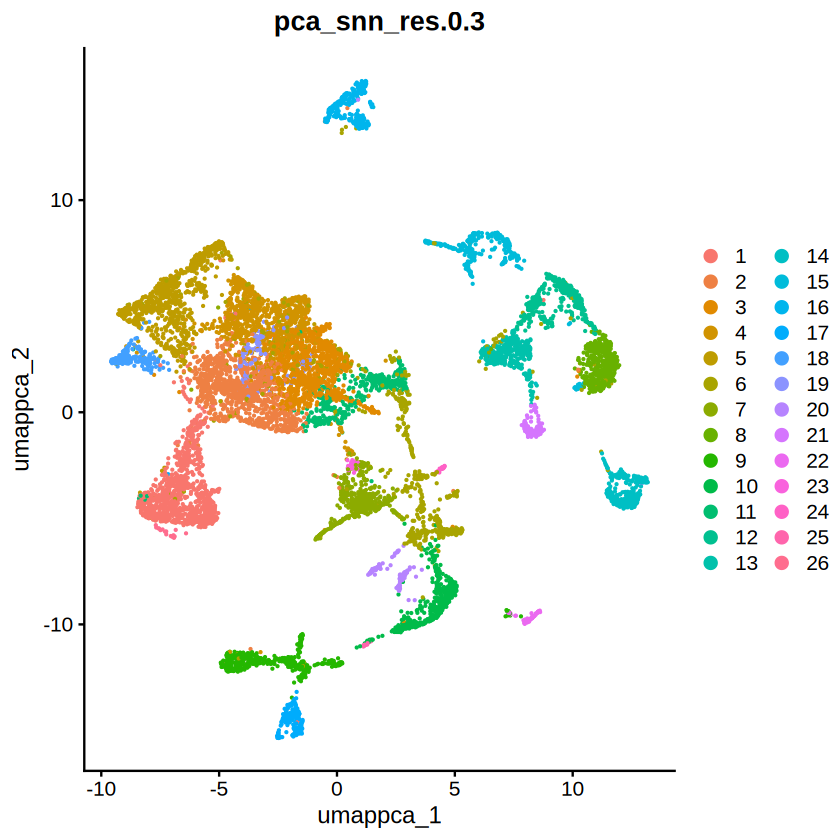

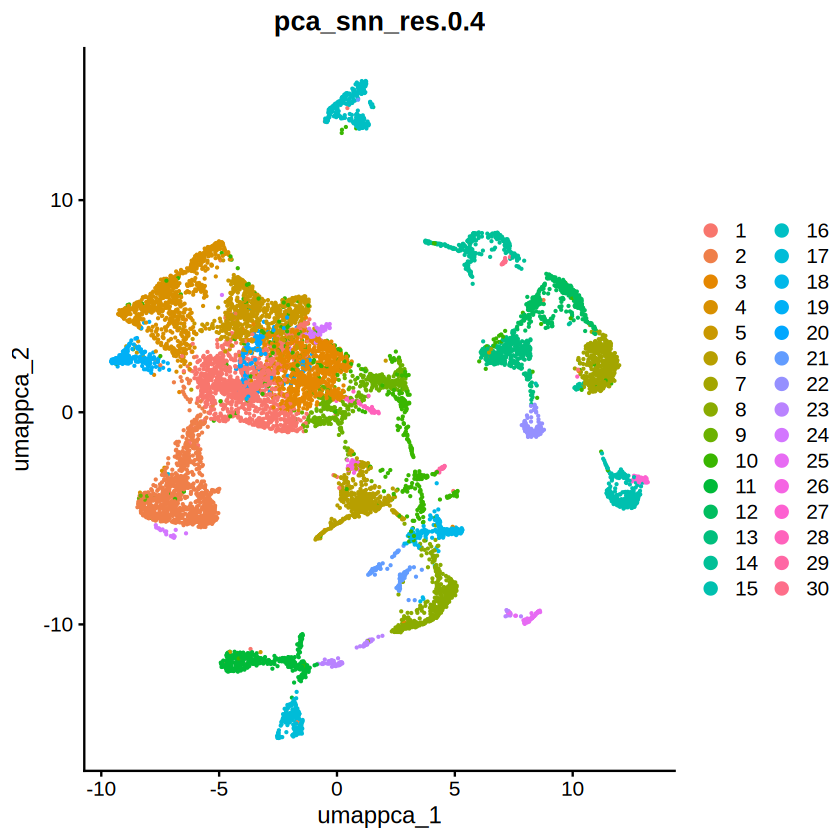

In [28]:
DimPlot(
  normalized_seurat,
  reduction = "umap_pca",
  group.by = c('orig.ident',
               'pca_snn_res.0.2',
               'pca_snn_res.0.3',
               'pca_snn_res.0.4'),
  combine = FALSE
)

## Data integration

In [3]:
normalized_seurat <- readRDS(file = here("seurat/normalized_seurat.rds"))
normalized_seurat

An object of class Seurat 
56194 features across 11105 samples within 2 assays 
Active assay: SCT (23673 features, 4000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

In [5]:
normalized_seurat <- IntegrateLayers(normalized_seurat,
                              normalization.method = "SCT",
                              method = HarmonyIntegration,
                              orig.reduction = "pca",
                              new.reduction = "harmony",
                              verbose = T
)

ERROR: [1m[33mError[39m in `method()`:[22m
[1m[22m[33m![39m The package "harmony" is required for running integration with Harmony
